In [2]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig


In [2]:
I_bx, I_fx, I_fy, m_all, w, l, l_f, f_d, T_gb, g, r, L = sp.symbols('I_bx, I_fx, I_fy, m_all, w, l, l_f, f_d, T_gb, g, r, L')
K_t, K_e, R, J_m, V, n, f = sp.symbols('K_t, K_e, R, J_m, V, n, f')
theta_R, theta_gb = dynamicsymbols('theta_R, theta_gb')

theta_Rd = theta_R.diff()
theta_Rdd = theta_Rd.diff()
theta_gbd = theta_gb.diff()
theta_gbdd = theta_gbd.diff()

q = sp.Matrix([[theta_R], [theta_gb]])
qd = q.diff()
qdd = qd.diff()

u = sp.Matrix([V])

L = I_fy * w / 2

# T_gb = (n*K_t*V)/R - sp.Pow(n,2)*J_m*theta_gbdd - sp.Pow(n,2)*(f+K_t*K_e/R)*theta_gbd + sp.Pow(n,2)*J_m*theta_Rdd + sp.Pow(n,2)*(f+K_t*K_e/R)*theta_Rd

tau = sp.Matrix([[I_bx*theta_Rdd - m_all*g*l*sp.sin(theta_R) + 2*L*theta_gbd*sp.cos(theta_gb)],
                 [2*I_fx*theta_gbdd - 2*L*theta_Rd*sp.cos(theta_gb) - T_gb]])
# - 2*L*theta_gbd*sp.cos(theta_gb)



In [3]:
tau# eq_point = {theta_gb:0,theta_R:0, theta_Rd**2:0}


Matrix([
[I_bx*Derivative(theta_R(t), (t, 2)) + I_fy*w*cos(theta_gb(t))*Derivative(theta_gb(t), t) - g*l*m_all*sin(theta_R(t))],
[                   2*I_fx*Derivative(theta_gb(t), (t, 2)) - I_fy*w*cos(theta_gb(t))*Derivative(theta_R(t), t) - T_gb]])

In [4]:
T_gb

T_gb

In [5]:
eq_point = {sp.sin(theta_gb):theta_gb, sp.cos(theta_gb):1,sp.sin(theta_R):theta_R, sp.cos(theta_R):1,theta_gbd**2:0 ,theta_Rd**2:0}
# eq_point = {theta_gb:0,theta_R:0, theta_Rd**2:0}

tau_eq = sp.simplify(tau.subs(eq_point))

In [6]:
tau_eq

Matrix([
[I_bx*Derivative(theta_R(t), (t, 2)) + I_fy*w*Derivative(theta_gb(t), t) - g*l*m_all*theta_R(t)],
[              2*I_fx*Derivative(theta_gb(t), (t, 2)) - I_fy*w*Derivative(theta_R(t), t) - T_gb]])

In [7]:
# RMD x6 Motor Dynamics

# R = 0.33    # Resistance (Ohm)
Kv = 60     # Speed constant (rpm/V)
# K_e = 1/Kv   # Back EMF Voltage constant (V/rpm)
# K_t = 0.88   # Torque constant (NM/A)
# Me = 0.7    # Motor efficiency
# I = 0.19    # Phase to phase inductance (mH)
# n = 6
J_m = 8e-5  #800[g*cm^2] = 8e-5[kg*m^2]


In [8]:
rpm = 5000
flywheel_ang_vel = (rpm * 2 * np.pi)/60 
flywheel_ang_vel

523.5987755982989

In [10]:
#무게중심_아래부터_위까지
m1 = 0.52           # ankle_wheel
m2 = 2.386          # ankle_roll_pitch
m3 = 1.231          # ankle_knee
m4 = 2.175          # knee_hip
m5 = 3.325          # hip_roll_pitch
m6 = 4*2+1*2+2.84   # cmg
mw = 2.292

l1 = 0.0087 + 0.138/2
l2 = 0.171+ 0.138/2
l3 = 0.171+0.159782+ 0.138/2
l4 = 0.171+0.279942+0.15984+ 0.138/2
l5 = 0.171+0.279942+0.28+ 0.138/2
l6 = 0.171+0.279942+0.28+0.21114+ 0.138/2
lw = 0.138/2

m_bb = 22.447 + 2.292

I_1 = 0.002000051
I_2 =0.003950987
I_3 =0.008859306
I_4 =0.007175717
I_5 = 0.006208194
I_6 = 0.09603070785702778
I_w =0.002997277

l_bb = (mw*lw + m1*l1 + m2*l2 + m3*l3 + m4*l4 + m5*l5 + m6*l6)/m_bb
l_bb

I_bb = I_w + I_1 + I_2 + I_3 + I_4 + I_5 + I_6 +  mw*(l_bb-lw)**2+  m1*(l_bb-l1)**2 +  m2*(l_bb-l2)**2 +  m3*(l_bb-l3)**2 +  m4*(l_bb-l4)**2 +  m5*(l_bb-l5)**2 +  m6*(l_bb-l6)**2
l_bb

0.7431161131007722

In [11]:
I_bb

3.089539709502296

In [12]:
Ml, Cl, Gl, Wl = get_EoM_from_T(tau_eq,qdd,g,u)

param = {w:flywheel_ang_vel, I_fx:0.005950, I_fy:0.011299999, I_bx:3.089539709502296,  m_all:25.278, r:0.069, l:1.022142,  g:9.81, R:0.33, K_t: 0.88, K_e: 0.88, J_m:8e-5, n: 6, f:0}

Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)

Mlp_inv = Mlp.inv()
qdd_rhs_A = Mlp_inv*(-Clp -Glp)
qdd_rhs_B = Mlp_inv*Wlp*u

X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u

A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)

ss0 = [A, B, C, D]
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

A = [[  0.           0.           1.           0.        ]
     [  0.           0.           0.           1.        ]
     [ 82.04066448   0.           0.          -1.91506379]
     [  0.           0.         497.19879333   0.        ]]

B = [[0.]
     [0.]
     [0.]
     [0.]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



In [8]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig

In [9]:
Aaa = np.array([[0,0,1,0],
              [0,0,0,1],
              [82.04066448,0,0,-1.91506379],
              [0,0,497.19879333, 0]])
    
Baa = np.array([[0],[0],[0],[84.03361345]])

Caa = np.eye(4)

Daa = np.array([[0], [0], [0], [0]])

In [26]:
d = 0.1

Aba = np.array([0, 0, 0, 0])
Aab = np.array([[0], [0], [0], [d]])
Abb = np.array([0])
Bb = np.array([0])

In [17]:
lamda, k1 = sympy.symbols('lamda, k1')
lamda, k1

(lamda, k1)

In [ ]:
I = sympy.Matrix([[1, 0],
                  [0, 1]])
I

In [25]:
Ts = 0.1
Sigma = np.array([-4.6/Ts])
K_est = control.place(Abb.T, Aab.T, Sigma)
L = K_est
L

IndexError: tuple index out of range

In [16]:
(Abb.T).shape[1]

IndexError: tuple index out of range

In [22]:
A = [[-1, -1], [0, 1]]
B = [[0], [1]]
K = control.place(A, B, [-2, -5])
K

array([[-4.,  7.]])

In [3]:
import modern_robotics as mr
import numpy as np

In [11]:
Slist = np.array([[0, 0,  1,  4, 0,    0],
                  [0, 0,  0,  0, 1,    0],
                  [0, 0, -1, -6, 0, -0.1]]).T
M = np.array([[-1, 0,  0, 0],
              [ 0, 1,  0, 6],
              [ 0, 0, -1, 2],
              [ 0, 0,  0, 1]])
T = np.array([[0, 1,  0,     -5],
              [1, 0,  0,      4],
              [0, 0, -1, 1.6858],
              [0, 0,  0,      1]])
thetalist0 = np.array([0, 0, 0])
eomg = 0.01
ev = 0.001

mr.IKinSpace(Slist, M, T, thetalist0, eomg, ev)

(array([1.57079651, 3.        , 3.14159284]), True)

In [13]:
M1 = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
Slist1 = np.array([[0, 0,  1,  4, 0,    0],
                          [0, 0,  0,  0, 1,    0],
                          [0, 0, -1, -6, 0, -0.1]]).T
thetalist = np.array([np.pi / 2.0, 3, np.pi])

mr.FKinSpace(M1, Slist1, thetalist)

array([[-1.14423775e-17,  1.00000000e+00,  0.00000000e+00,
        -5.00000000e+00],
       [ 1.00000000e+00,  1.14423775e-17,  0.00000000e+00,
         4.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         1.68584073e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [12]:
Slist1

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 1. ,  0. , -1. ],
       [ 4. ,  0. , -6. ],
       [ 0. ,  1. ,  0. ],
       [ 0. ,  0. , -0.1]])

In [28]:
matrix_rank(control.obsv(A,C))

4

In [29]:
matrix_rank(control.ctrb(A,C))

4

In [14]:
A

Matrix([
[               0, 0, 1,                 0],
[               0, 0, 0,                 1],
[82.0406644847403, 0, 0, -3.83012758985715],
[               0, 0, 0,                 0]])

In [14]:
ss0 = [A, B, C, D]
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

TypeError: can't convert expression to float

In [8]:
sys0_output = sys0[2,0]
mprint(sys0_output)
tf_20 = tf_clean(control.minreal(control.ss2tf(sys0_output)))
tf_20

A = [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
     [ 1.23270243e+01  0.00000000e+00  0.00000000e+00 -3.69286070e-01]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.47536922e+02]]

B = [[ 0.        ]
     [ 0.        ]
     [ 0.        ]
     [84.03361345]]

C = [[0. 0. 1. 0.]]

D = [[0.]]

0 states have been removed from the model


TransferFunction(array([-31.03244287,   0.        ]), array([ 1.00000000e+00, -4.47536922e+02, -1.23270243e+01,  5.51679850e+03]))

In [9]:
eig(np.array(A, dtype=float))

(array([  3.51098622,  -3.51098622,   0.        , 447.53692198]),
 array([[ 2.73926095e-01, -2.73926095e-01,  0.00000000e+00,
         -1.84387163e-06],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          2.23444617e-03],
        [ 9.61750745e-01,  9.61750745e-01,  0.00000000e+00,
         -8.25200635e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          9.99997163e-01]]))

In [13]:
# control.bode(tf_20);

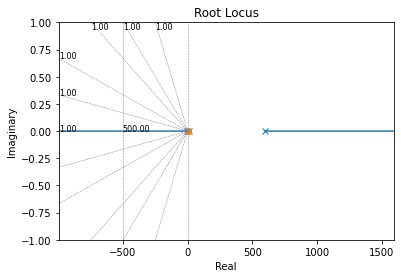

In [14]:
control.rlocus(tf_20);

[[-1720.72753484   -38.72983345  -247.69831922    27.79607196]]


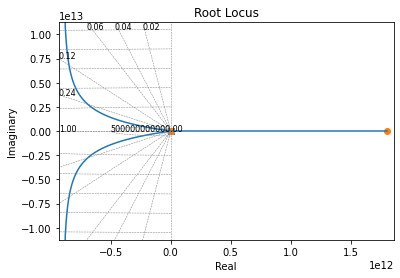

In [15]:
Q = sp.Matrix([ [89,0,0,0],
                [0,15,0,0],
                [0,0,26,0],
                [0,0,0,4.7]])
R = sp.Matrix([ [0.01] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)

print(K)

sysc = sys0.feedback(K)
control.rlocus(sysc);

In [16]:
eig(np.array(A-B*K, dtype=float))


(array([-2.50129011e+03, -9.19701078e+00, -1.73260411e+00, -5.47020139e+00]),
 array([[ 2.61962714e-07, -4.34440541e-02,  2.99934249e-02,
         -7.25905672e-02],
        [ 3.99793571e-04, -9.89793091e-02, -4.98979599e-01,
          1.64526261e-01],
        [-6.55244745e-04,  3.99555434e-01, -5.19667310e-02,
          3.97085022e-01],
        [-9.99999705e-01,  9.10313773e-01,  8.64534102e-01,
         -8.99991780e-01]]))

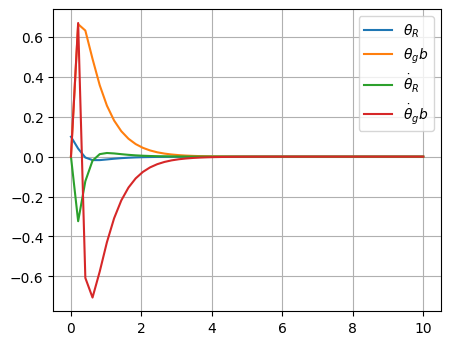

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x0 = [0.1, 0, 0, 0]
u = 0
dt = 0.01
tf = 10

t, y = control.forced_response(sysc, X0=x0, T=pl.linspace(0,tf), transpose=True)

plt.figure(1, figsize=(5,4), dpi=100)
plt.plot(t, y);
plt.legend([r'$\theta_R$',r'$\theta_gb$',r'$\dot\theta_R$',r'$\dot\theta_gb$'], loc='best')
plt.grid()